In [1]:
import glob

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from astropy.io import fits


In [2]:
import argparse
import glob
import importlib
import os
import time

In [3]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from plotly import subplots
from plotly  import __version__
print(__version__)

py.offline.init_notebook_mode(connected=True)

4.4.1


In [4]:
#%matplotlib notebook
%matplotlib inline

import matplotlib.pylab as plt


In [5]:
from gplot import *
gplot.tmp = '$'
gplot.colors('classic')
from pause import pause

In [6]:
from inst.inst_TLS import Spectrum, Tpl, FTS
import vpr


In [53]:
import numpy as np
from scipy import interpolate


c = 3e5   # [km/s] speed of light

# IP sampling in velocity space
# index k for IP space
def IP(vk, s=2.2):
    IP_k = np.exp(-(vk/s)**2)   # Gauss IP
    #IP_k += 0.07*np.exp(-((vk+1.)/s)**2)   # an asymmetry Gauss IP
    IP_k /= IP_k.sum()          # normalise IP
    return IP_k

def IP_sg(vk, s=2.2, e=2.):
    # super Gaussian
    IP_k = np.exp(-abs(vk/s)**e)   # Gauss IP
    IP_k /= IP_k.sum()          # normalise IP
    return IP_k

def IP2(vk, s):
    ''' IP for multiple, zero-centered Gaussians '''
    print(s)
    s0, a1, s1 = s
    IP_k = np.exp(-(vk/s0)**2)   # Gauss IP
    IP_k += a1*np.exp(-(vk/s1)**2)   # Gauss IP
    IP_k /= IP_k.sum()          # normalise IP
    return IP_k

IPs = {'g':IP, 'sg': IP_sg}


class model:
    '''
    The forward model
    
    '''
    def __init__(self, *args, IP_hw=50):
        self.S_star, self.xj, self.iod_j, self.IP = args
        # convolving with IP will reduce the valid wavelength range
        self.dx = self.xj[1] - self.xj[0]  # sampling in uniform resampled Iod
        self.vk = np.arange(-IP_hw,IP_hw+1) * self.dx * c
        self.xj_eff = self.xj[IP_hw:-IP_hw]
        #print("sampling [km/s]:", self.dx*c)

    def __call__(self, i, v, a, b, s):
        # wavelength solution
        xi = np.log(np.poly1d(b[::-1])(i))
        # IP convolution
        Sj_eff = np.convolve(self.IP(self.vk, s), self.S_star(self.xj+v/c) * self.iod_j, mode='valid')
        # sampling to pixel
        Si_eff = interpolate.interp1d(self.xj_eff, Sj_eff)(xi)
        # flux normalisation
        Si_mod = np.poly1d(a[::-1])(xi) * Si_eff
        return Si_mod
    
    
    def show(self, p, x, y, res=True, x2=None, dx=None):
        '''
        res: Show residuals.
        x2: Values for second x axis.
        dx: Subpixel step size for the model [pixel].

        '''
        ymod = self(x, *p)
        x2 = np.poly1d(p[2][::-1])(x)
        
        trace0 = go.Scatter(x=x,
                   y=y,
                   mode='markers+lines',
                   name='data',
                   marker=dict(size=12,color='rgba(155,60,0,0.5)'))
        trace1 = go.Scatter(x=x,
                   y=ymod,
                   mode='markers+lines',
                   name='model',
                   marker=dict(size=12,color='rgba(55,60,155,0.8)'))

        


        
        prms = np.nan   # percentage prms
        if dx:
            xx = np.arange(x.min(), x.max(), dx)
            xx2 = np.poly1d(p[2][::-1])(xx)
            yymod = self(xx, *p)
            tracedx = go.Scatter(x=xx,
                   y=yymod,
                   mode='markers',
                   name='residual spectrum',
                   marker=dict(size=12,color='rgba(0,190,255,0.9)'))

            fig = subplots.make_subplots(rows=2,
                                     cols=1,
                                     subplot_titles=('Model','residual'),shared_xaxes=True)

            fig.append_trace(trace0,1,1)
            fig.add_trace(trace1,1,1)

            fig.append_trace(tracedx,2,1)

            fig.layout.update(title="Model of the spectrum")

            iplot(fig)        
        elif res:
            rms = np.std(y-ymod)
            prms = rms / np.mean(ymod) * 100
            # overplot residuals
            
            traceres = go.Scatter(x=x,
                               y=y-ymod,
                               mode='markers',
                               name='residual spectrum',
                               marker=dict(size=12,color='rgba(0,190,255,0.9)'))
            
            fig = subplots.make_subplots(rows=3,
                                     cols=1,
                                     subplot_titles=('Model','residual'),shared_xaxes=True)

            fig.append_trace(trace0,1,1)
            fig.add_trace(trace1,1,1)

            fig.append_trace(tracedx,2,1)
            fig.append_trace(traceres,3,1)

            fig.layout.update(title="Model of the spectrum")

            iplot(fig)      
        else:
            fig = subplots.make_subplots(rows=1,
                                 cols=1,
                                 subplot_titles=('Model','residual'))

            fig.append_trace(trace0,1,1)
            fig.add_trace(trace1,1,1)


            fig.layout.update(title="Model of the spectrum")

            iplot(fig)        

            
        return prms


def show_model(x, y, ymod, res=True,x2=1):
    if res:
        rms = np.std(y-ymod)

        trace0 = go.Scatter(x=x,
                   y=y,
                   mode='markers+lines',
                   name='observed',
                   marker=dict(size=12,color='rgba(155,60,0,0.5)'))
        trace1 = go.Scatter(x=x,
                   y=ymod,
                   mode='markers+lines',
                   name='modelled',
                   marker=dict(size=12,color='rgba(55,60,155,0.8)'))

        trace2 = go.Scatter(x=x,
                           y=y-ymod,
                           mode='markers',
                           name='residual spectrum',
                           marker=dict(size=12,color='rgba(0,190,255,0.9)'))

        fig = subplots.make_subplots(rows=2,
                                 cols=1,
                                 subplot_titles=('Model','residual'),shared_xaxes=True)

        fig.append_trace(trace0,1,1)
        fig.add_trace(trace1,1,1)

        fig.append_trace(trace2,2,1)

        fig.layout.update(title="Modelling of the spectrum")

        iplot(fig)
        
    else:
        rms = np.std(y-ymod)

        trace0 = go.Scatter(x=x,
                   y=y,
                   mode='markers+lines',
                   name='observed',
                   marker=dict(size=12,color='rgba(155,60,0,0.5)'))
        trace1 = go.Scatter(x=x,
                   y=ymod,
                   mode='markers+lines',
                   name='modelled',
                   marker=dict(size=12,color='rgba(55,60,155,0.8)'))


        fig = subplots.make_subplots(rows=1,
                                 cols=1,
                                 subplot_titles=('Model'),shared_xaxes=True)

        
        fig.append_trace(trace0,1,1)
        fig.add_trace(trace1,1,1)


        fig.layout.update(title="Modelling of the spectrum")

        iplot(fig)

In [29]:
c = 3e5   # [km/s] speed of light

o = 19; lmin = 5240; lmax = 5390

dirname = r''
v0 = -12
ftsname = dirname + 'lib/TLS/FTS/TLS_I2_FTS.fits'
obsname = dirname + 'data/TLS/betgem/BETA_GEM.fits'
tplname = dirname + 'data/TLS/betgem/pepsib.20150409.000.sxt.awl.all6'
obsname = dirname + 'data/TLS/hd189733/TV00001.fits'
tplname = dirname + 'data/TLS/Deconv/HD189733.model'
tplname = dirname + 'data/TLS/Deconv/HARPS.2006-09-08T02:12:38.604_s1d_A.fits'

nset = None


In [30]:
####  FTS  ####

# using the supersampled log(wavelength) space with knot index j

w_I2, f_I2, xj_full, iod_j_full = FTS()



ID      ='File ratio of scans 002 & 001                                       '  [astropy.io.fits.card]
DAY     ='07/24/01  '           / Date (mm/dd/yy, MST)                           [astropy.io.fits.card]


In [31]:

orders = np.r_[19:20] # np.arange(18,30)
print(orders)


[19]


In [32]:
rv = np.nan * orders
e_rv = np.nan * orders


In [33]:
obsname = '/home/sireesha/Desktop/TLS_model/stage10/VIPER/data/TLS/hd189733/TV00001.fits'

In [34]:
tplname='/home/sireesha/Desktop/TLS_model/stage10/VIPER/data/TLS/Deconv/HARPS.2006-09-08T02:12:38.604_s1d_A.fits'

In [35]:
####  data TLS  ####
w_i, f_i, bp, bjd, berv = Spectrum(obsname, o=o)
i = np.arange(f_i.size)




In [36]:
mskatm = interp1d(*np.genfromtxt('lib/mask_vis1.0.dat').T)
bp[mskatm(w_i) > 0.1] |= 16
i_ok, = np.where(bp==0)

In [37]:
####  stellar template  ####
w_tpl, f_tpl = Tpl(tplname, o=o)

lmin = max(w_tpl[0], w_i[0], w_I2[0])
lmax = min(w_tpl[-1], w_i[-1], w_I2[-1])

# display
# pre-look raw input
s = slice(*np.searchsorted(w_I2, [lmin, lmax]))
s_s = slice(*np.searchsorted(w_tpl, [lmin, lmax]))


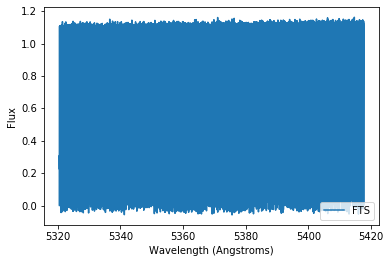

In [38]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

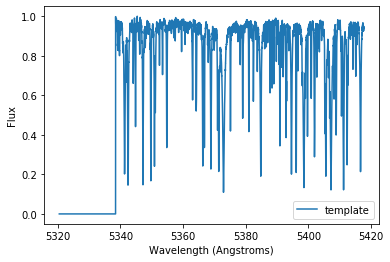

In [39]:
s_s = slice(*np.searchsorted(w_tpl, [lmin, lmax]))

plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label='template')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

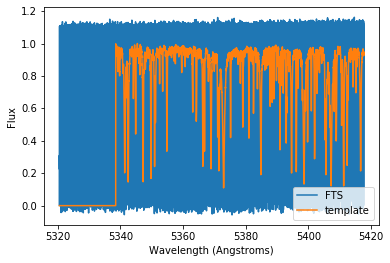

In [40]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label='template')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

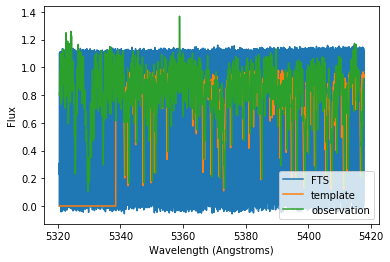

In [41]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label= 'template')
plt.plot(w_i, f_i, label='observation')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()


In [42]:
vcut = 30
sj = slice(*np.searchsorted(xj_full, [np.log(lmin)+vcut/c, np.log(lmax)-vcut/c])) # reduce range by 100 km/s

# prepare input; convert discrete data to model

# using the supersampled log(wavelength) space with knot index j
xj = xj_full[sj]
iod_j = iod_j_full[sj]


In [43]:
# convert discrete template into a function
S_star = interp1d(np.log(w_tpl)-berv/c, f_tpl)

In [57]:
# setup the model
IP = IPs['g']
S_mod = model(S_star, xj, iod_j, IP)

In [58]:
S_mod = model(S_star, xj, iod_j, IP)

In [59]:
trace=go.Scatter(x=S_mod.vk,
                y=S_mod.IP(S_mod.vk),
                mode='lines+markers',
                marker=dict(size=16))

data=[trace]

layout={'title':'IP interms of velocity sampling','xaxis':{'zeroline':False}}

iplot({'data':data,'layout':layout})

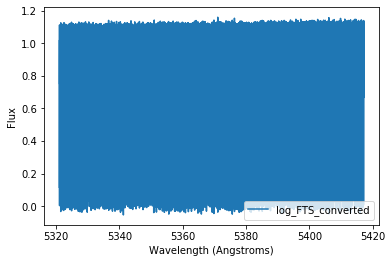

In [60]:
plt.plot(np.exp(xj), iod_j, label='log_FTS_converted')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()


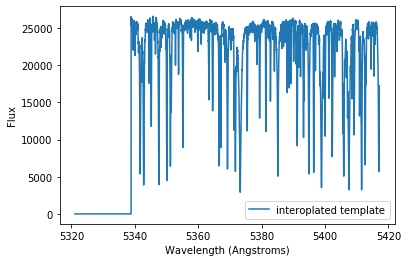

In [61]:
plt.plot(np.exp(xj),S_star(xj), label= 'interoplated template')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()


In [62]:
# Now wavelength solution

# mapping between pixel and wavelength

#lam(x) = b0 + b1 * x + b2 * x^2
lam = np.poly1d([w_i[0], (w_i[-1]-w_i[0])/w_i.size][::-1])

# trim the observation to a range valid for the model
i_ok = slice(*np.searchsorted(np.log(w_i), [xj[0]+100/c, xj[-1]-100/c]))

In [63]:
i_ok = np.r_[i_ok][bp[i_ok]==0]

In [64]:
vg =0
ip='g'

In [65]:
# a parameter set
v = vg   # a good guess for the stellar RV is needed
a = ag = [np.mean(f_i) / np.mean(S_star(np.log(w_i[i_ok])))] 
b = bg = [w_i[0], (w_i[-1]-w_i[0])/w_i.size] # [6128.8833940969, 0.05453566108124]
b = bg = np.polyfit(i[i_ok], w_i[i_ok], 3)[::-1]
#show_model(i[i_ok], f_i[i_ok], S_b(i[i_ok],*bg), res=False)
s = sg = [1.] if ip=='g' else [1., 2.]

In [66]:
S_mod.show([v,a,b,s], i[i_ok], f_i[i_ok], res=False, dx=0.1)

nan